# Libs

In [98]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os

from datetime import datetime
import calendar
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series


from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series

# Leitura dos dados

In [2]:
# Caminho da pasta
pasta = r'C:\Users\feh_s\case_wiz_co\data\novos_dados'

# Lista todos os arquivos na pasta
arquivos = os.listdir(pasta)

# Loop para ler cada arquivo e atribuir o nome do dataframe
for arquivo in arquivos:
    # Verifica se o arquivo é um arquivo CSV (ou ajuste para o formato correto, se necessário)
    if arquivo.endswith('.csv'):
        # Extrai o nome do arquivo sem a extensão para atribuir como nome do dataframe
        nome_dataframe = os.path.splitext(arquivo)[0]
        
        # Lê o arquivo e atribui ao dataframe com o nome correspondente
        caminho_completo = os.path.join(pasta, arquivo)
        globals()[nome_dataframe] = pd.read_csv(caminho_completo, encoding='utf-8', sep=';')
        print(nome_dataframe)


df_inadimplencia
df_receita
df_venda
receitas
vendas


# Informações iniciais sobre os dados

In [3]:
receitas.head()

,ano,mes,seguradora,vendedor,tot_apolices,receita
0,2019,1,72,58,1,"65,3"
1,2019,1,72,57,4,"1360,235"
2,2019,1,72,56,3,"276,49"
3,2019,1,72,47,2,"-1707,095"
4,2019,1,72,38,3,"1080,745"


In [4]:
vendas.head()

,ano,mes,seguradora,vendedor,tot_apolices,venda
0,2019,1,66,1,1,"174,055"
1,2019,1,31,58,1,"92,31"
2,2019,1,72,35,6,"900,08"
3,2019,1,55,20,1,7550
4,2019,1,72,58,2,"84,175"


In [5]:
dataframes = [receitas, vendas]
for df in dataframes:
    print("Informações do DataFrame:")
    print(df.info())
    print("-"*50)

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ano           1080 non-null   int64 
 1   mes           1080 non-null   int64 
 2   seguradora    1080 non-null   int64 
 3   vendedor      1080 non-null   int64 
 4   tot_apolices  1080 non-null   int64 
 5   receita       1080 non-null   object
dtypes: int64(5), object(1)
memory usage: 50.8+ KB
None
--------------------------------------------------
Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ano           1242 non-null   int64 
 1   mes           1242 non-null   int64 
 2   seguradora    1242 non-null   int64 
 3   vendedor      1242 non-null   int64 
 4   tot_apolices  1242 non-null   int64 

# Limpeza dos dados

In [6]:
def extrair_valor_monetario(df, colunas):
    for coluna in colunas:
        df[coluna] = df[coluna].str.replace('.', '').str.replace(',', '.').astype(float)
    return df

In [7]:
def extrair_valor_monetario(df, colunas):
    df[colunas] = df[colunas].apply(lambda x: x.str.replace('.', '').str.replace(',', '.').astype(float))
    return df

In [8]:
print(vendas.columns)
print(receitas.columns)

Index(['ano', 'mes', 'seguradora', 'vendedor', 'tot_apolices', 'venda'], dtype='object')
Index(['ano', 'mes', 'seguradora', 'vendedor', 'tot_apolices', 'receita'], dtype='object')


## Colunas de seguradora e vendedor para string

In [9]:
receitas[['seguradora', 'vendedor']] = receitas[['seguradora', 'vendedor']].applymap(str)
vendas[['seguradora', 'vendedor']] = vendas[['seguradora', 'vendedor']].applymap(str)


## Valores nulos coluna de venda/receita para int

In [10]:
# vendas.loc[:, 'venda'] = vendas['venda'].apply(lambda x: float(x.replace('.', '').replace(',', '.')))
receitas.loc[:, 'receita'] = receitas['receita'].apply(lambda x: float(x.replace('.', '').replace(',', '.')))
receitas['receita'] = pd.to_numeric(receitas['receita'])

In [11]:
receitas['receita'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1080 entries, 0 to 1079
Series name: receita
Non-Null Count  Dtype  
--------------  -----  
1080 non-null   float64
dtypes: float64(1)
memory usage: 8.6 KB


In [12]:
vendas_is_null = vendas.loc[vendas['venda'].isnull()]
vendas_is_null

,ano,mes,seguradora,vendedor,tot_apolices,venda
56,2019,1,81,2,1,NaN
95,2019,2,81,2,1,NaN
584,2019,9,68,22,1,NaN
763,2019,12,77,2,1,NaN


In [13]:
venda_not_null = vendas[~vendas['venda'].isnull()]
# venda_not_null['venda'] = venda_not_null['venda'].str.replace(',', '.').astype('float')
venda_not_null.loc[:, 'venda'] = venda_not_null['venda'].apply(lambda x: float(x.replace('.', '').replace(',', '.')))
venda_not_null['venda'] = pd.to_numeric(venda_not_null['venda'])

C:\Users\feh_s\AppData\Local\Temp\ipykernel_11276\311048895.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venda_not_null['venda'] = pd.to_numeric(venda_not_null['venda'])


In [14]:
venda_not_null.loc[venda_not_null['vendedor'] == '2']

,ano,mes,seguradora,vendedor,tot_apolices,venda
19,2019,1,66,2,1,87.175
37,2019,1,72,2,3,485.390
43,2019,1,31,2,1,2389.950
70,2019,2,66,2,1,262.795
153,2019,3,81,2,1,1115.910
334,2019,6,72,2,1,354.735
361,2019,6,74,2,1,58.350
373,2019,6,66,2,1,75.005
403,2019,7,66,2,2,130.875
440,2019,7,72,2,4,56.030


In [15]:
print(
    venda_not_null
    .loc[
        (venda_not_null['vendedor'] == '2')
        & (venda_not_null['ano'] == 2019)
        & (venda_not_null['mes'] == 1)
        ]
    .groupby('vendedor')['venda']
    .mean()
)

print(
    venda_not_null
    .loc[
        (venda_not_null['vendedor'] == '2')
        & (venda_not_null['ano'] == 2019)
        & (venda_not_null['mes'] == 2)
        ]
    .groupby('vendedor')['venda']
    .mean()
)

print(
    venda_not_null
    .loc[
        (venda_not_null['vendedor'] == '22')
        & (venda_not_null['ano'] == 2019)
        & (venda_not_null['mes'] == 9)
        ]
    .groupby('vendedor')['venda']
    .mean()
)

print(
    venda_not_null
    .loc[
        (venda_not_null['vendedor'] == '2')
        & (venda_not_null['ano'] == 2019)
        & (venda_not_null['mes'] == 12)
        ]
    .groupby('vendedor')['venda']
    .mean()
)

vendedor
2    987.505
Name: venda, dtype: float64
vendedor
2    262.795
Name: venda, dtype: float64
vendedor
22    156.1275
Name: venda, dtype: float64
vendedor
2    221.8575
Name: venda, dtype: float64


In [16]:
vendas.loc[vendas['venda'].isnull()]

,ano,mes,seguradora,vendedor,tot_apolices,venda
56,2019,1,81,2,1,NaN
95,2019,2,81,2,1,NaN
584,2019,9,68,22,1,NaN
763,2019,12,77,2,1,NaN


In [17]:
vendas.loc[56, 'venda'] = '987,505'
vendas.loc[95, 'venda'] = '262,795'
vendas.loc[584, 'venda'] = '156,1275'
vendas.loc[763, 'venda'] = '221,8575'

In [18]:
vendas.loc[:, 'venda'] = vendas['venda'].apply(lambda x: float(x.replace('.', '').replace(',', '.')))
vendas['venda'] = pd.to_numeric(vendas['venda'])
vendas.head()

,ano,mes,seguradora,vendedor,tot_apolices,venda
0,2019,1,66,1,1,174.055
1,2019,1,31,58,1,92.310
2,2019,1,72,35,6,900.080
3,2019,1,55,20,1,7550.000
4,2019,1,72,58,2,84.175


## Criando colunas datetime 

In [19]:
receitas['date'] = pd.to_datetime(receitas['ano'].astype(str) + '-' + receitas['mes'].astype(str), format='%Y-%m')
vendas['date'] = pd.to_datetime(vendas['ano'].astype(str) + '-' + vendas['mes'].astype(str), format='%Y-%m')

In [20]:
receitas

,ano,mes,seguradora,vendedor,tot_apolices,receita,date
0,2019,1,72,58,1,65.300,2019-01-01
1,2019,1,72,57,4,1360.235,2019-01-01
2,2019,1,72,56,3,276.490,2019-01-01
3,2019,1,72,47,2,-1707.095,2019-01-01
4,2019,1,72,38,3,1080.745,2019-01-01
...,...,...,...,...,...,...,...
1075,2020,6,72,14,1,98.935,2020-06-01
1076,2020,6,72,13,3,3244.695,2020-06-01
1077,2020,6,72,12,3,267.235,2020-06-01
1078,2020,6,72,9,12,2157.955,2020-06-01


## Coluna de total venda/receita

In [21]:
vendas['total_venda'] = vendas['tot_apolices'] * vendas['venda']
receitas['total_receita'] = receitas['tot_apolices'] * receitas['receita']

# Análise exploratória

In [22]:
receitas.describe()

,ano,mes,tot_apolices,receita,date,total_receita
count,1080.000000,1080.000000,1080.00000,1080.000000,1080,1080.000000
mean,2019.352778,5.695370,3.32963,1201.460574,2019-09-28 22:51:59.999999744,5426.334954
min,2019.000000,1.000000,1.00000,-4622.065000,2019-01-01 00:00:00,-40964.000000
25%,2019.000000,3.000000,1.00000,109.560000,2019-06-01 00:00:00,144.767500
50%,2019.000000,5.000000,2.00000,309.747500,2019-10-01 00:00:00,668.162500
75%,2020.000000,8.000000,4.00000,959.635000,2020-02-01 00:00:00,3315.712500
max,2020.000000,12.000000,34.00000,125950.595000,2020-06-01 00:00:00,215018.040000
std,0.478056,3.195626,3.61808,4632.482693,NaN,15838.419240


In [23]:
vendas.describe()

,ano,mes,tot_apolices,venda,date,total_venda
count,1242.000000,1242.000000,1242.000000,1242.000000,1242,1242.000000
mean,2019.359903,5.566023,3.416264,1262.376864,2019-09-27 15:44:55.652174080,6471.948921
min,2019.000000,1.000000,1.000000,-61874.485000,2019-01-01 00:00:00,-232804.470000
25%,2019.000000,3.000000,1.000000,92.590000,2019-06-01 00:00:00,116.263750
50%,2019.000000,5.000000,2.000000,254.617500,2019-10-01 00:00:00,546.947500
75%,2020.000000,8.000000,4.000000,842.583750,2020-02-01 00:00:00,2993.902500
max,2020.000000,12.000000,36.000000,148598.290000,2020-06-01 00:00:00,891589.740000
std,0.480165,3.261018,3.798065,6876.339591,NaN,34681.789944


## Qual a distribuição de apolices e receitas/vendas?

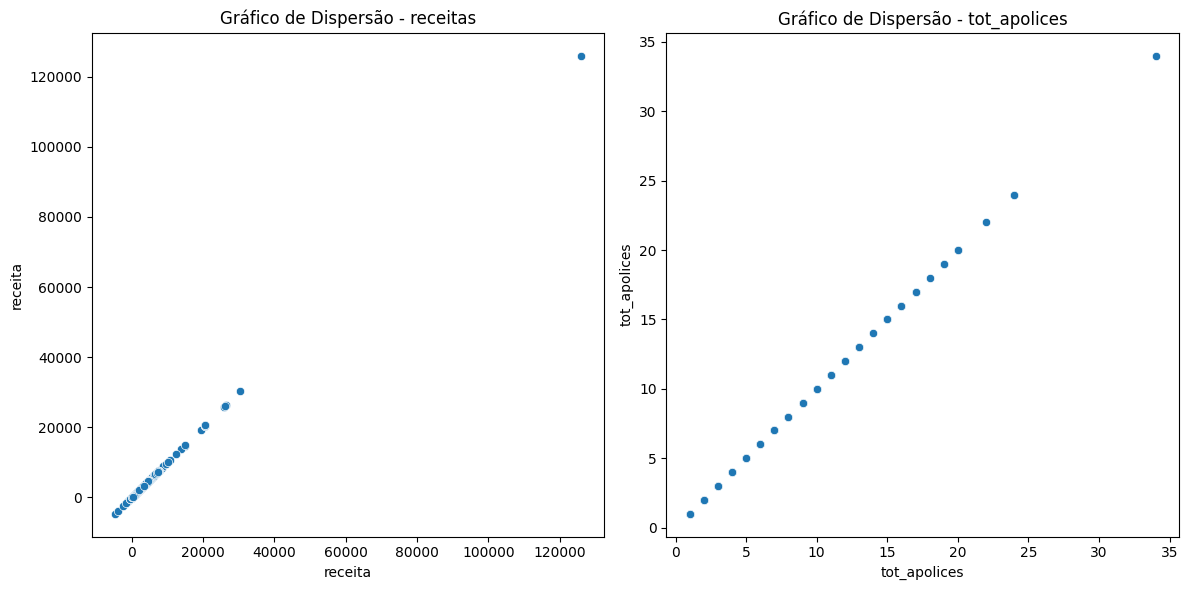

In [24]:
# Criando subplots (1 linha e 2 colunas)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de dispersão 1
sns.scatterplot(x='receita', y='receita', data=receitas, ax=axs[0])
axs[0].set_title('Gráfico de Dispersão - receitas')
axs[0].set_xlabel('receita')
axs[0].set_ylabel('receita')

# Gráfico de dispersão 2
sns.scatterplot(x='tot_apolices', y='tot_apolices', data=receitas, ax=axs[1])
axs[1].set_title('Gráfico de Dispersão - tot_apolices')
axs[1].set_xlabel('tot_apolices')
axs[1].set_ylabel('tot_apolices')

# Ajustando o espaçamento entre os subplots e exibindo o gráfico
plt.tight_layout()
plt.show()


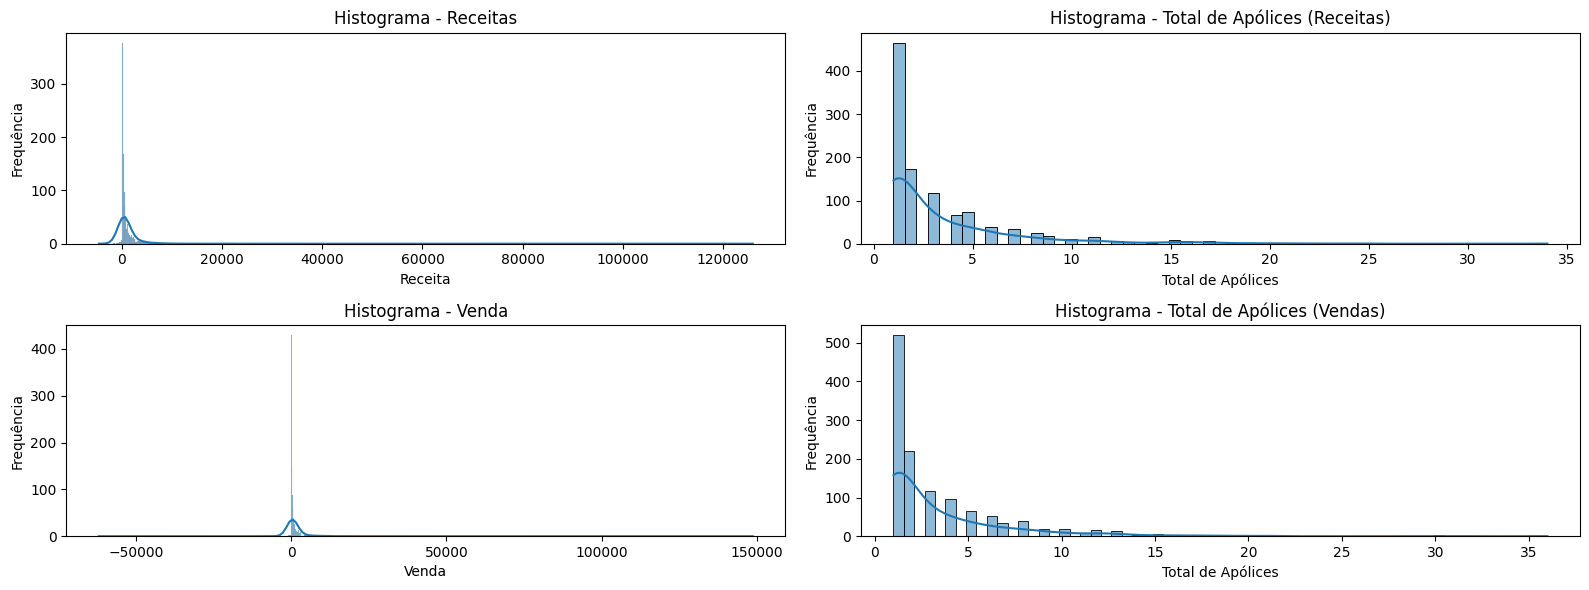

In [25]:
# Criando subplots (1 linha e 2 colunas)
fig, axs = plt.subplots(2, 2, figsize=(16, 6))

# Histograma receitas
sns.histplot(data=receitas, x='receita', ax=axs[0, 0], kde=True)
axs[0, 0].set_title('Histograma - Receitas')
axs[0, 0].set_xlabel('Receita')
axs[0, 0].set_ylabel('Frequência')

# Histograma apolices de receitas
sns.histplot(data=receitas, x='tot_apolices', ax=axs[0, 1], kde=True)
axs[0, 1].set_title('Histograma - Total de Apólices (Receitas)')
axs[0, 1].set_xlabel('Total de Apólices')
axs[0, 1].set_ylabel('Frequência')

# Histograma vendas
sns.histplot(data=vendas, x='venda', ax=axs[1, 0], kde=True)
axs[1, 0].set_title('Histograma - Venda')
axs[1, 0].set_xlabel('Venda')
axs[1, 0].set_ylabel('Frequência')

# Histograma apolices de vendas
sns.histplot(data=vendas, x='tot_apolices', ax=axs[1, 1], kde=True)
axs[1, 1].set_title('Histograma - Total de Apólices (Vendas)')
axs[1, 1].set_xlabel('Total de Apólices')
axs[1, 1].set_ylabel('Frequência')

# Ajustando o espaçamento entre os subplots e exibindo o gráfico
plt.tight_layout()
plt.show()


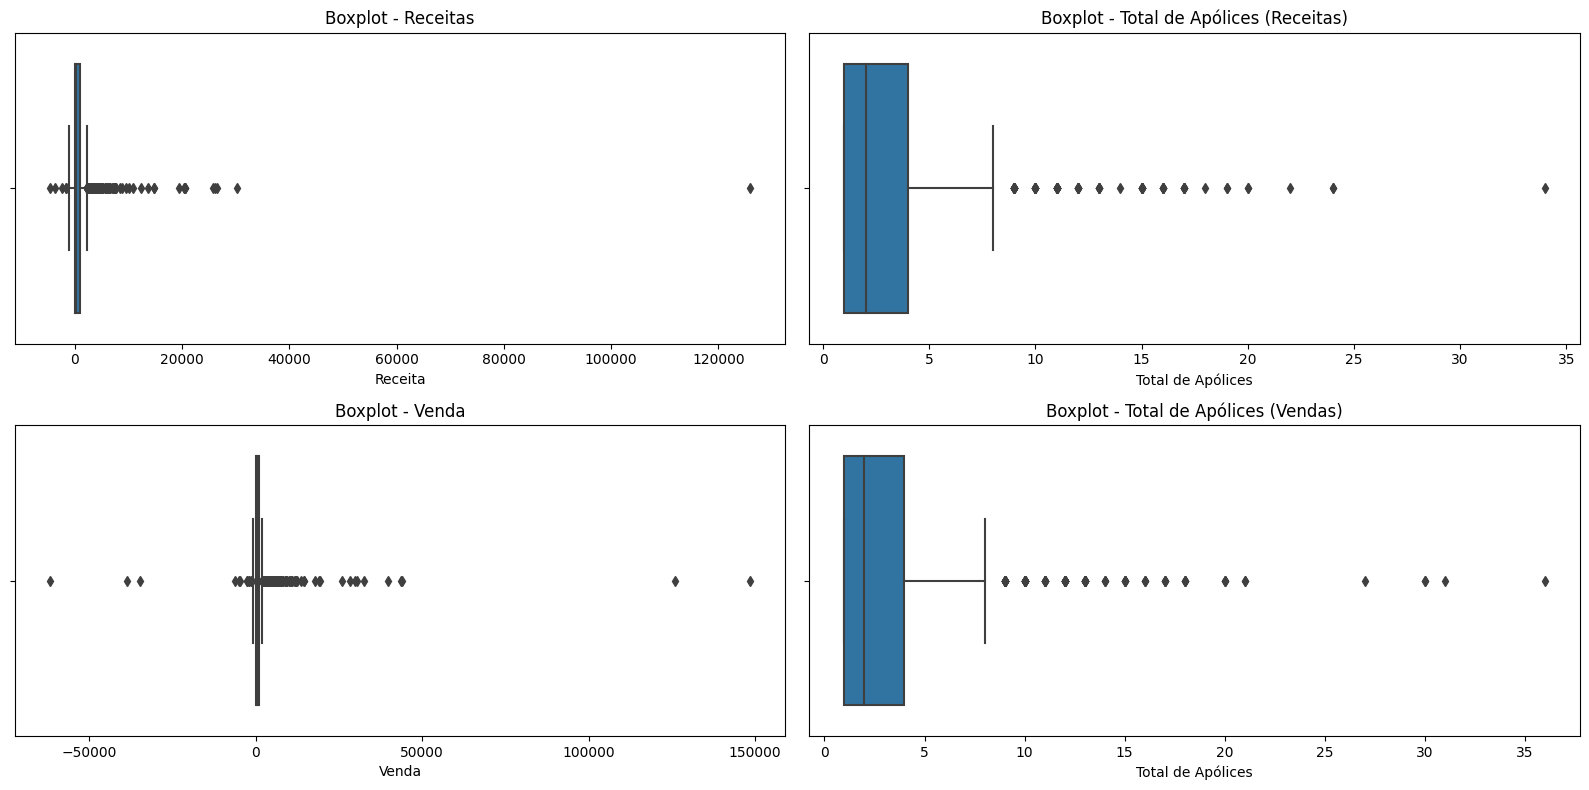

In [26]:
# Criando subplots (1 linha e 2 colunas)
fig, axs = plt.subplots(2, 2, figsize=(16, 8))

# Boxplot receitas
sns.boxplot(data=receitas, x='receita', ax=axs[0, 0])
axs[0, 0].set_title('Boxplot - Receitas')
axs[0, 0].set_xlabel('Receita')

# Boxplot apolices de receitas
sns.boxplot(data=receitas, x='tot_apolices', ax=axs[0, 1])
axs[0, 1].set_title('Boxplot - Total de Apólices (Receitas)')
axs[0, 1].set_xlabel('Total de Apólices')

# Boxplot vendas
sns.boxplot(data=vendas, x='venda', ax=axs[1, 0])
axs[1, 0].set_title('Boxplot - Venda')
axs[1, 0].set_xlabel('Venda')

# Boxplot apolices de vendas
sns.boxplot(data=vendas, x='tot_apolices', ax=axs[1, 1])
axs[1, 1].set_title('Boxplot - Total de Apólices (Vendas)')
axs[1, 1].set_xlabel('Total de Apólices')

# Ajustando o espaçamento entre os subplots e exibindo o gráfico
plt.tight_layout()
plt.show()


### Não tem como saber, apenas olhando para os dados, se esses outliars estão corretos ou não, mas tenho que tomar cuidado ao utilizar a média desses valores. Porque eles puxam a estatística muito para cima.

## Vendas vs Receitas

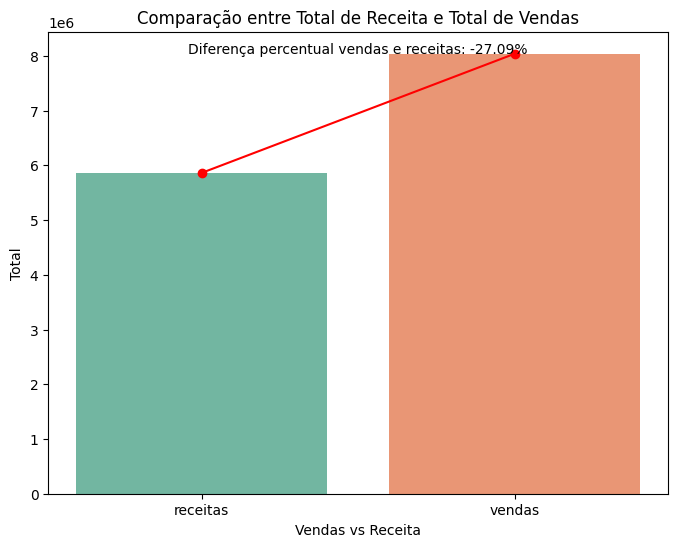

In [27]:
# Criar um novo DataFrame para consolidar os dados
data = {
    'DataFrame': ['receitas', 'vendas'],
    'Total': [receitas['total_receita'].sum(), vendas['total_venda'].sum()]
}
df_total = pd.DataFrame(data)

# Calcular a diferença percentual entre as duas barras
total_receita = receitas['total_receita'].sum()
total_vendas = vendas['total_venda'].sum()
diff_percent = ((total_receita - total_vendas) / total_vendas) * 100


# Criar o gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x='DataFrame', y='Total', data=df_total, palette='Set2')

# Adicionar a linha conectando as colunas
plt.plot([0, 1], [total_receita, total_vendas], marker='o', color='red')

# Adicionar texto com a diferença percentual
plt.text(0.5, max(total_receita, total_vendas), f'Diferença percentual vendas e receitas: {diff_percent:.2f}%', ha='center')

# Configurações do gráfico
plt.xlabel('Vendas vs Receita')
plt.ylabel('Total')
plt.title('Comparação entre Total de Receita e Total de Vendas')
plt.show()


## Total de receita/venda por ano

In [28]:
receitas.groupby('ano')['receita'].sum().reset_index()

,ano,receita
0,2019,747908.20
1,2020,549669.22


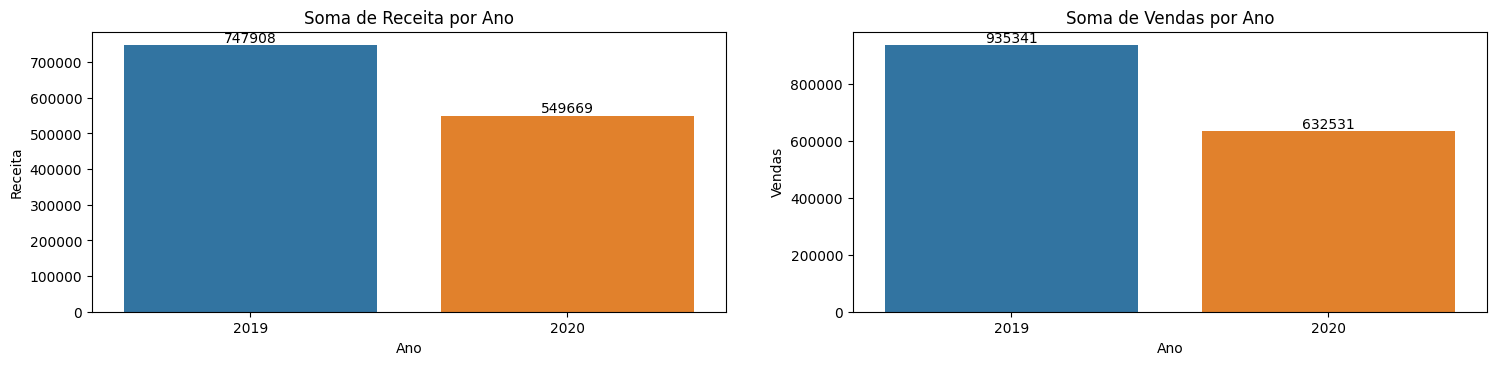

In [29]:
plt.figure(figsize=(18,8))
plt.tight_layout(pad=1.15, h_pad=1.5, w_pad=1.15, rect=None)

# Plotar gráfico usando Seaborn
group_receitas = receitas.groupby('ano')['receita'].sum().reset_index()

plt.subplot(221)
ax1 = sns.barplot(x='ano', y='receita', data=group_receitas, errwidth=0)

# Configurações do gráfico
plt.xlabel('Ano')
plt.ylabel('Receita')
plt.title('Soma de Receita por Ano')

# Exibir o gráfico
for container in ax1.containers:
    ax1.bar_label(container)

# Gráfico de vendas
group_vendas = vendas.groupby('ano')['venda'].sum().reset_index()

plt.subplot(222)
ax2 = sns.barplot(x='ano', y='venda', data=group_vendas, errwidth=0)

# Configurações do gráfico
plt.xlabel('Ano')
plt.ylabel('Vendas')
plt.title('Soma de Vendas por Ano')

# Exibir o gráfico
for container in ax2.containers:
    ax2.bar_label(container)

## Total de vendas e receitas no primeiro semestre

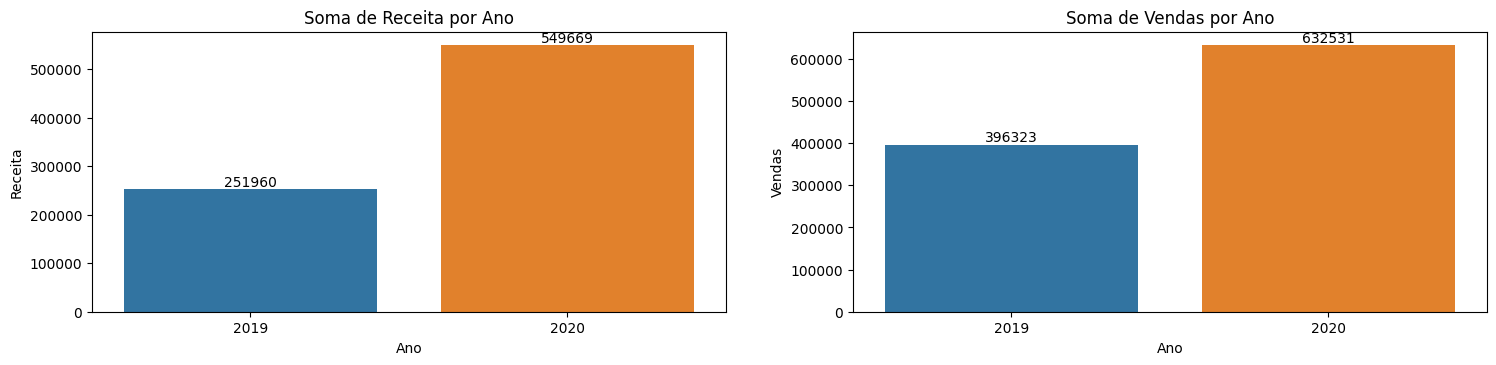

In [30]:
plt.figure(figsize=(18,8))
plt.tight_layout(pad=1.15, h_pad=1.5, w_pad=1.15, rect=None)

# Plotar gráfico usando Seaborn
group_receitas = receitas.loc[receitas['mes']<=6].groupby('ano')['receita'].sum().reset_index()

plt.subplot(221)
ax1 = sns.barplot(x='ano', y='receita', data=group_receitas, errwidth=0)

# Configurações do gráfico
plt.xlabel('Ano')
plt.ylabel('Receita')
plt.title('Soma de Receita por Ano')

# Exibir o gráfico
for container in ax1.containers:
    ax1.bar_label(container)

# Gráfico de vendas
group_vendas = vendas.loc[vendas['mes']<=6].groupby('ano')['venda'].sum().reset_index()

plt.subplot(222)
ax2 = sns.barplot(x='ano', y='venda', data=group_vendas, errwidth=0)

# Configurações do gráfico
plt.xlabel('Ano')
plt.ylabel('Vendas')
plt.title('Soma de Vendas por Ano')

# Exibir o gráfico
for container in ax2.containers:
    ax2.bar_label(container)

# O primeiro semestre de 2020 é bem melhor que o de 2019

## Vendas e receitas por mês

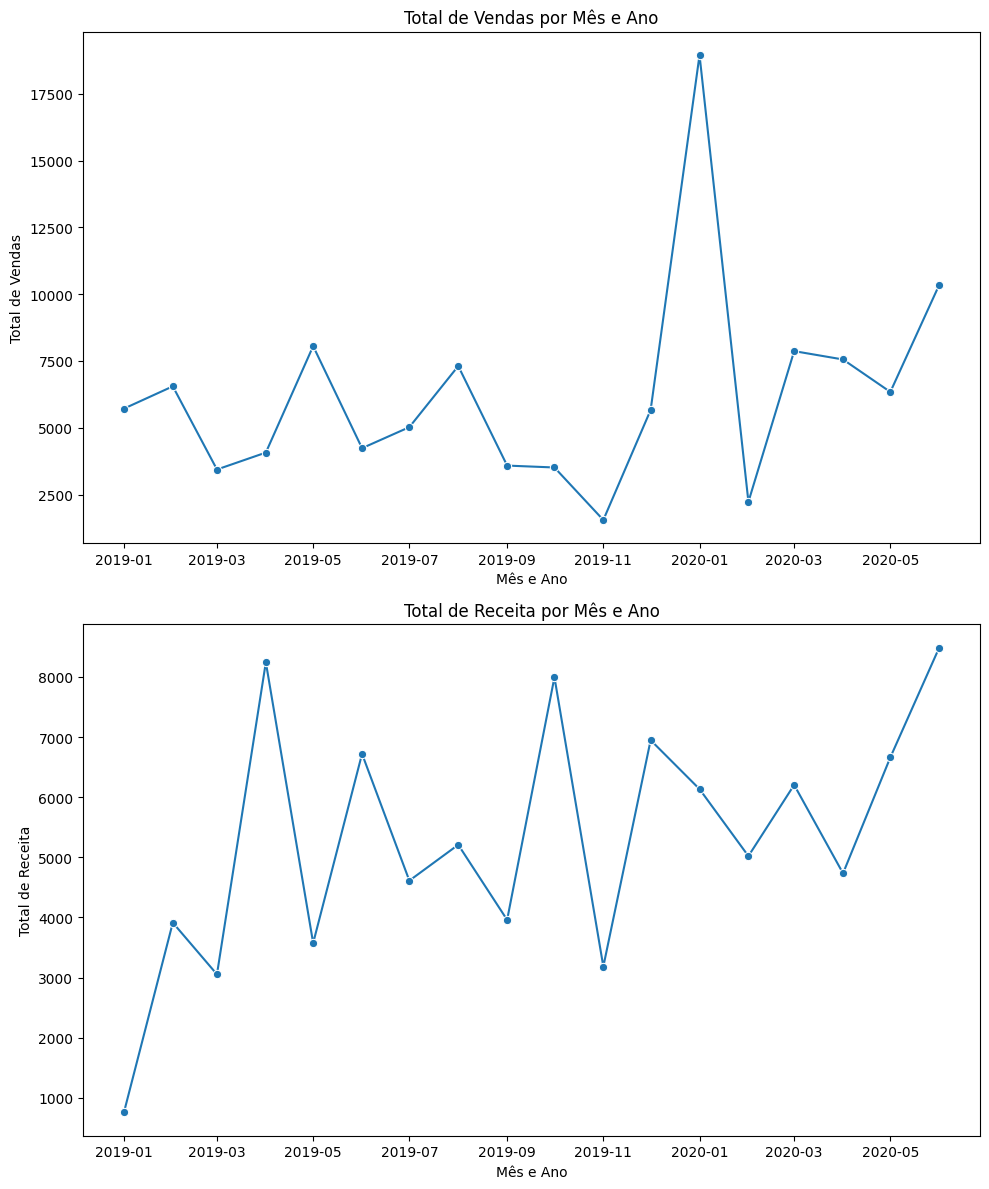

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criar subplots (2 linhas e 1 coluna)
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Gráfico de linhas para 'tot_venda'
sns.lineplot(x='date', y='total_venda', data=vendas, ax=axs[0], marker='o', errorbar=None)
axs[0].set_title('Total de Vendas por Mês e Ano')
axs[0].set_xlabel('Mês e Ano')
axs[0].set_ylabel('Total de Vendas')
# axs[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: pd.to_datetime(x).strftime('%Y-%m')))

# Gráfico de linhas para 'total_receita'
sns.lineplot(x='date', y='total_receita', data=receitas, ax=axs[1], marker='o', errorbar=None)
axs[1].set_title('Total de Receita por Mês e Ano')
axs[1].set_xlabel('Mês e Ano')
axs[1].set_ylabel('Total de Receita')
# axs[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: pd.to_datetime(x).strftime('%Y-%m')))

# Ajustar layout e exibir o gráfico
plt.tight_layout()
plt.show()


## Melhores vendedores e seguradora

In [32]:
(
    vendas
    .groupby('seguradora')['total_venda']
    .sum()
    .nlargest(5)
)

seguradora
72    3097354.620
31    2295611.100
55    1105263.180
66     914831.275
44     277583.485
Name: total_venda, dtype: float64

In [33]:
(
    vendas
    .groupby('vendedor')['total_venda']
    .sum()
    .nlargest(5)
)

vendedor
16    1906657.980
20    1567811.915
35    1055091.580
12     569963.370
38     495330.880
Name: total_venda, dtype: float64

In [34]:
# A seguradora 55 vende mais que a 66, mas traz menos receita.
(
    receitas
    .groupby('seguradora')['total_receita']
    .sum()
    .nlargest(5)
)

seguradora
72    2859984.640
31    1118626.195
66     866958.310
55     471128.485
44     245468.280
Name: total_receita, dtype: float64

In [35]:
(
    receitas
    .groupby('vendedor')['total_receita']
    .sum()
    .nlargest(5)
)

vendedor
16    1733428.055
20     584024.270
38     476346.110
12     469670.225
35     383517.920
Name: total_receita, dtype: float64

## Inadimplência

In [36]:
receitas_group = (
    receitas
    .groupby(['seguradora', 'date'])['total_receita']
    .sum()
)

# Transformar a Series em um DataFrame
receitas_group_df = receitas_group.reset_index()

vendas_group = (
    vendas
    .groupby(['seguradora', 'date'])['total_venda']
    .sum()
)

# Transformar a Series em um DataFrame
vendas_group_df = vendas_group.reset_index()

# inadimplente = 

In [37]:
inadimplencia = vendas_group_df.merge(receitas_group_df, how='left', on=['date', 'seguradora'])

inadimplencia['total_receita'] = inadimplencia['total_receita'].fillna(0)
inadimplencia['total_venda'] = inadimplencia['total_venda'].fillna(0)
inadimplencia['valor_recebido'] = inadimplencia['total_receita'] - inadimplencia['total_venda']




In [38]:
inadimplencia.head()

,seguradora,date,total_venda,total_receita,valor_recebido
0,13,2019-02-01,166.880,0.00,-166.880
1,13,2019-04-01,322.520,0.00,-322.520
2,13,2019-05-01,127.325,0.00,-127.325
3,13,2019-07-01,199.525,360.81,161.285
4,13,2019-09-01,54.925,0.00,-54.925


In [39]:
receitas.loc[
    (receitas['seguradora'] == '13')
    & (receitas['mes'] == 2)
    ]

,ano,mes,seguradora,vendedor,tot_apolices,receita,date,total_receita
760,2020,2,13,16,1,122.12,2020-02-01,122.12


In [40]:
receitas.loc[
    (receitas['seguradora'] == '13')
    & ((receitas['mes'] == 2) | (receitas['mes'] == 3))
    & (receitas['ano'] == 2019)
    ]

,ano,mes,seguradora,vendedor,tot_apolices,receita,date,total_receita
132,2019,3,13,57,1,146.975,2019-03-01,146.975


## Inadimplência total

In [41]:
receitas_group = (
    receitas
    .groupby(['seguradora'])['total_receita']
    .sum()
)

# Transformar a Series em um DataFrame
receitas_group_df = receitas_group.reset_index()

vendas_group = (
    vendas
    .groupby(['seguradora'])['total_venda']
    .sum()
)

# Transformar a Series em um DataFrame
vendas_group_df = vendas_group.reset_index()

In [42]:
inadimplencia = vendas_group_df.merge(receitas_group_df, how='left', on=['seguradora'])
inadimplencia['valor_recebido'] = inadimplencia['total_receita'] - inadimplencia['total_venda']

inadimplencia['total_receita'] = inadimplencia['total_receita'].fillna(0)
inadimplencia['total_venda'] = inadimplencia['total_venda'].fillna(0)

In [43]:
inadimplencia['status'] = (
    np.where(
        inadimplencia['valor_recebido'] > 0, 'Não inadimplente', 
        'Inadimplente'
    )
)
inadimplencia

,seguradora,total_venda,total_receita,valor_recebido,status
0,13,1.792210e+03,1922.230,1.300200e+02,Não inadimplente
1,19,-2.512195e+04,2111.970,2.723392e+04,Não inadimplente
2,21,9.320557e+04,69075.570,-2.413000e+04,Inadimplente
3,23,3.745615e+04,30474.945,-6.981210e+03,Inadimplente
4,24,2.122975e+03,86.000,-2.036975e+03,Inadimplente
5,31,2.295611e+06,1118626.195,-1.176985e+06,Inadimplente
6,33,3.292150e+02,0.000,NaN,Inadimplente
7,35,1.404340e+04,5013.680,-9.029720e+03,Inadimplente
8,38,1.209970e+03,243.450,-9.665200e+02,Inadimplente
9,4,2.825015e+03,1437.505,-1.387510e+03,Inadimplente


In [44]:
inadimplencia['status'].value_counts(normalize=True)

status
Inadimplente        0.8125
Não inadimplente    0.1875
Name: proportion, dtype: float64

In [45]:
inadimplencia['seguradora'].value_counts()

seguradora
13    1
19    1
81    1
79    1
78    1
77    1
75    1
74    1
72    1
68    1
66    1
64    1
62    1
6     1
58    1
56    1
55    1
54    1
51    1
44    1
43    1
42    1
41    1
4     1
38    1
35    1
33    1
31    1
24    1
23    1
21    1
83    1
Name: count, dtype: int64

In [46]:
# inadimplencia['seguradora'].value_counts()[lambda x: x <= 3]
inadimplencia.loc[inadimplencia['status'] == 'Inadimplente']['seguradora'].value_counts() / 18

seguradora
21    0.055556
23    0.055556
79    0.055556
78    0.055556
77    0.055556
75    0.055556
72    0.055556
68    0.055556
66    0.055556
62    0.055556
6     0.055556
58    0.055556
56    0.055556
55    0.055556
51    0.055556
44    0.055556
43    0.055556
42    0.055556
41    0.055556
4     0.055556
38    0.055556
35    0.055556
33    0.055556
31    0.055556
24    0.055556
81    0.055556
Name: count, dtype: float64

In [47]:
vendas.loc[vendas['seguradora'] == '78']

,ano,mes,seguradora,vendedor,tot_apolices,venda,date,total_venda
42,2019,1,78,25,1,50.0,2019-01-01,50.0
110,2019,2,78,25,1,50.0,2019-02-01,50.0
159,2019,3,78,25,1,50.0,2019-03-01,50.0
195,2019,4,78,25,1,50.0,2019-04-01,50.0
245,2019,5,78,25,1,50.0,2019-05-01,50.0
312,2019,6,78,25,1,50.0,2019-06-01,50.0
394,2019,7,78,25,1,50.0,2019-07-01,50.0
525,2019,8,78,25,1,50.0,2019-08-01,50.0
591,2019,9,78,25,1,50.0,2019-09-01,50.0
650,2019,10,78,25,1,50.0,2019-10-01,50.0


In [48]:
receitas.loc[receitas['seguradora'] == '78']

,ano,mes,seguradora,vendedor,tot_apolices,receita,date,total_receita


In [49]:
inadimplencia.loc[inadimplencia['seguradora'] == '78']

,seguradora,total_venda,total_receita,valor_recebido,status
28,78,900.0,0.0,NaN,Inadimplente


In [50]:
vendas.loc[vendas['seguradora'] == '13']['total_venda'].sum()

1792.21

In [51]:
(
    vendas
    .groupby('seguradora')['total_venda']
    .sum()
)

seguradora
13    1.792210e+03
19   -2.512195e+04
21    9.320557e+04
23    3.745615e+04
24    2.122975e+03
31    2.295611e+06
33    3.292150e+02
35    1.404340e+04
38    1.209970e+03
4     2.825015e+03
41    1.065258e+04
42    3.378290e+03
43    2.393435e+03
44    2.775835e+05
51    9.097725e+03
54   -5.750719e+04
55    1.105263e+06
56    1.264132e+04
58    9.199400e+02
6     3.210117e+04
62    3.289589e+04
64    3.731683e+04
66    9.148313e+05
68    3.062175e+02
72    3.097355e+06
74    5.559440e+03
75    6.735120e+03
77    1.123721e+05
78    9.000000e+02
79    1.168240e+03
81    5.525380e+03
83    3.197820e+03
Name: total_venda, dtype: float64

In [52]:
pd.options.display.float_format = '{:.2f}'.format
inadimplencia

,seguradora,total_venda,total_receita,valor_recebido,status
0,13,1792.21,1922.23,130.02,Não inadimplente
1,19,-25121.95,2111.97,27233.92,Não inadimplente
2,21,93205.57,69075.57,-24130.00,Inadimplente
3,23,37456.15,30474.95,-6981.21,Inadimplente
4,24,2122.97,86.00,-2036.97,Inadimplente
5,31,2295611.10,1118626.20,-1176984.91,Inadimplente
6,33,329.21,0.00,NaN,Inadimplente
7,35,14043.40,5013.68,-9029.72,Inadimplente
8,38,1209.97,243.45,-966.52,Inadimplente
9,4,2825.01,1437.51,-1387.51,Inadimplente


In [53]:
inadimplencia['status'] = (
    np.where(
        inadimplencia['valor_recebido'] > 0, 'Não inadimplente', 
        'Inadimplente'
    )
)

In [54]:
inadimplencia

,seguradora,total_venda,total_receita,valor_recebido,status
0,13,1792.21,1922.23,130.02,Não inadimplente
1,19,-25121.95,2111.97,27233.92,Não inadimplente
2,21,93205.57,69075.57,-24130.00,Inadimplente
3,23,37456.15,30474.95,-6981.21,Inadimplente
4,24,2122.97,86.00,-2036.97,Inadimplente
5,31,2295611.10,1118626.20,-1176984.91,Inadimplente
6,33,329.21,0.00,NaN,Inadimplente
7,35,14043.40,5013.68,-9029.72,Inadimplente
8,38,1209.97,243.45,-966.52,Inadimplente
9,4,2825.01,1437.51,-1387.51,Inadimplente


In [55]:
(
    receitas
    .groupby(['seguradora'])['total_receita']
    .sum()
    .loc['13']
)

1922.23

In [56]:
(
    vendas
    .groupby(['seguradora'])['total_venda']
    .sum()
    .loc['13']
)

1792.21

## Inadimplência mensal

In [90]:
receitas_group = (
    receitas
    .groupby(['seguradora', 'date'])['total_receita']
    .sum()
)

# Transformar a Series em um DataFrame
receitas_group_df = receitas_group.reset_index()

vendas_group = (
    vendas
    .groupby(['seguradora', 'date'])['total_venda']
    .sum()
)

# Transformar a Series em um DataFrame
vendas_group_df = vendas_group.reset_index()



inadimplência_mensal = vendas_group_df.merge(receitas_group_df, how='outer', on=['seguradora', 'date'])

inadimplência_mensal['total_receita'] = inadimplência_mensal['total_receita'].fillna(0)
inadimplência_mensal['total_venda'] = inadimplência_mensal['total_venda'].fillna(0)


inadimplência_mensal['valor_recebido'] = inadimplência_mensal['total_receita'] - inadimplência_mensal['total_venda']


In [91]:
inadimplência_mensal['status'] = (
    np.where(
        inadimplência_mensal['valor_recebido'] > 0, 'Não inadimplente', 
        'Inadimplente'
    )
)
inadimplência_mensal

,seguradora,date,total_venda,total_receita,valor_recebido,status
0,13,2019-02-01,166.88,0.00,-166.88,Inadimplente
1,13,2019-04-01,322.52,0.00,-322.52,Inadimplente
2,13,2019-05-01,127.33,0.00,-127.33,Inadimplente
3,13,2019-07-01,199.52,360.81,161.29,Não inadimplente
4,13,2019-09-01,54.92,0.00,-54.92,Inadimplente
...,...,...,...,...,...,...
311,81,2020-04-01,0.00,689.54,689.54,Não inadimplente
312,83,2019-08-01,0.00,702.51,702.51,Não inadimplente
313,83,2019-09-01,0.00,685.86,685.86,Não inadimplente
314,83,2019-10-01,0.00,775.81,775.81,Não inadimplente


In [177]:
(
    inadimplência_mensal.groupby('seguradora')['status']
    .apply(lambda x: (x == 'Inadimplente').mean() * 100)
    .reset_index(name='porcentagem_inadimplente')
    .sort_values('porcentagem_inadimplente')
)

,seguradora,porcentagem_inadimplente
12,43,25.00
22,66,27.78
15,54,28.57
1,19,37.50
31,83,41.67
29,79,42.86
25,74,44.44
21,64,44.44
0,13,50.00
2,21,50.00


In [179]:
seguradoras_filtro = ['33', '78', '68', '4', '62', '56', '51', '58']
filtro = inadimplência_mensal['seguradora'].isin(seguradoras_filtro)
inadimplência_mensal[filtro]['seguradora'].value_counts()

seguradora
78    18
62     7
33     3
58     3
56     2
68     2
4      1
51     1
Name: count, dtype: int64

In [ ]:
inadimplência_mensal.loc[inadimplência_mensal['status'] == 'Inadimplente']['seguradora'].value_counts() / inadimplência_mensal['numero_de_meses_inadimplente'].max()


In [ ]:
inadimplência_mensal.loc[inadimplência_mensal['status'] == 'Inadimplente']['seguradora'].value_counts() / 18

In [ ]:
inadimplência_mensal['taxa_inadimplencia'] = 

In [92]:
inadimplência_mensal.loc[(inadimplência_mensal['seguradora']=='13')]

,seguradora,date,total_venda,total_receita,valor_recebido,status
0,13,2019-02-01,166.88,0.00,-166.88,Inadimplente
1,13,2019-04-01,322.52,0.00,-322.52,Inadimplente
2,13,2019-05-01,127.33,0.00,-127.33,Inadimplente
3,13,2019-07-01,199.52,360.81,161.29,Não inadimplente
4,13,2019-09-01,54.92,0.00,-54.92,Inadimplente
5,13,2019-11-01,136.14,0.00,-136.14,Inadimplente
6,13,2019-12-01,153.93,369.87,215.94,Não inadimplente
7,13,2020-01-01,186.97,187.82,0.85,Não inadimplente
8,13,2020-02-01,121.30,122.12,0.82,Não inadimplente
9,13,2020-04-01,192.47,109.16,-83.31,Inadimplente


In [65]:
inadimplência_mensal['status'].value_counts(normalize=True)

status
Inadimplente        0.68
Não inadimplente    0.32
Name: proportion, dtype: float64

In [97]:
inadimplência_mensal.loc[inadimplência_mensal['status'] == 'Inadimplente']['seguradora'].value_counts() / 18

seguradora
78   1.00
55   0.67
23   0.67
31   0.61
44   0.56
72   0.56
21   0.50
77   0.44
64   0.44
6    0.44
75   0.39
62   0.39
13   0.39
35   0.33
66   0.28
42   0.28
81   0.28
83   0.28
74   0.22
58   0.17
38   0.17
19   0.17
33   0.17
24   0.17
79   0.17
56   0.11
41   0.11
68   0.11
54   0.11
43   0.11
4    0.06
51   0.06
Name: count, dtype: float64

## Inadimplênica MoM

In [67]:
# Suponha que 'vendas' e 'receitas' sejam os dataframes com as colunas 'seguradora', 'total_venda', 'total_receita' e 'date'

# 1. Agrupar dataframes por mês e seguradora e somar as colunas relevantes
vendas_grouped = vendas.groupby(['seguradora', pd.Grouper(key='date', freq='M')])['total_venda'].sum().reset_index()
receitas_grouped = receitas.groupby(['seguradora', pd.Grouper(key='date', freq='M')])['total_receita'].sum().reset_index()

# 2. Merge dos dataframes por mês e seguradora
merged_df = pd.merge(vendas_grouped, receitas_grouped, on=['seguradora', 'date'], how='outer')

# 3. Preencher valores ausentes com zero nas colunas 'total_receita' e 'total_venda'
merged_df['total_receita'] = merged_df['total_receita'].fillna(0)
merged_df['total_venda'] = merged_df['total_venda'].fillna(0)

# 3. Criação da coluna de inadimplência MoM
merged_df['inadimplencia_mom'] = merged_df['total_venda'] - merged_df['total_receita']



# 4. Filtragem dos valores positivos (não inadimplência) e negativos (inadimplência)
merged_df['status_mom'] = merged_df['inadimplencia_mom'].apply(lambda x: 'Não inadimplente' if x > 0 else 'Inadimplente')

# Exemplo de saída do dataframe com a coluna de inadimplência MoM
inadimplencia_df = merged_df[['seguradora', 'date', 'total_receita', 'total_venda', 'inadimplencia_mom', 'status_mom']].sort_values(['seguradora', 'date'])

inadimplencia_df

,seguradora,date,total_receita,total_venda,inadimplencia_mom,status_mom
0,13,2019-02-28,0.000,166.880,166.880,Não inadimplente
275,13,2019-03-31,146.975,0.000,-146.975,Inadimplente
1,13,2019-04-30,0.000,322.520,322.520,Não inadimplente
2,13,2019-05-31,0.000,127.325,127.325,Não inadimplente
276,13,2019-06-30,538.705,0.000,-538.705,Inadimplente
...,...,...,...,...,...,...
313,83,2019-09-30,685.860,0.000,-685.860,Inadimplente
314,83,2019-10-31,775.810,0.000,-775.810,Inadimplente
273,83,2019-12-31,0.000,147.715,147.715,Não inadimplente
315,83,2020-03-31,82.575,0.000,-82.575,Inadimplente


In [89]:
vendas.loc[vendas['seguradora']== '13'].sort_values(['date']).groupby(['date'])['total_venda'].sum()

date
2019-02-01   166.88
2019-04-01   322.52
2019-05-01   127.33
2019-07-01   199.52
2019-09-01    54.92
2019-11-01   136.14
2019-12-01   153.93
2020-01-01   186.97
2020-02-01   121.30
2020-04-01   192.47
2020-06-01   130.24
Name: total_venda, dtype: float64

In [88]:
receitas.loc[receitas['seguradora']== '13'].sort_values('date').groupby(['date'])['total_receita'].sum()

date
2019-03-01   146.97
2019-06-01   538.70
2019-07-01   360.81
2019-10-01    86.78
2019-12-01   369.87
2020-01-01   187.82
2020-02-01   122.12
2020-04-01   109.16
Name: total_receita, dtype: float64

In [95]:
inadimplência_mensal.loc[(inadimplência_mensal['seguradora']=='13')].sort_values('date')['valor_recebido']

130.01999999999998

In [82]:
inadimplencia.loc[inadimplencia['seguradora']== '13']

,seguradora,total_venda,total_receita,valor_recebido,status
0,13,1792.21,1922.23,130.02,Não inadimplente


In [67]:
merged_df = pd.merge(vendas[['seguradora', 'date', 'total_venda']],
                     receitas[['seguradora', 'date', 'total_receita']],
                     on=['seguradora', 'date'], how='outer')
merged_df = merged_df.sort_values(['seguradora', 'date'])
merged_df.loc[merged_df['seguradora']== '13']

,seguradora,date,total_venda,total_receita
1024,13,2019-02-01,166.88,NaN
12964,13,2019-03-01,NaN,146.97
2299,13,2019-04-01,322.52,NaN
2759,13,2019-05-01,73.38,NaN
2760,13,2019-05-01,53.95,NaN
12969,13,2019-06-01,NaN,314.14
12970,13,2019-06-01,NaN,224.56
4866,13,2019-07-01,76.85,110.30
4867,13,2019-07-01,76.85,250.51
4868,13,2019-07-01,122.67,110.30


In [74]:
# Cálculo MoM para cada seguradora
merged_df = pd.merge(vendas[['seguradora', 'date', 'total_venda']],
                     receitas[['seguradora', 'date', 'total_receita']],
                     on=['seguradora', 'date'], how='inner')
merged_df = merged_df.sort_values(['seguradora', 'date'])

# Calculando a variação MoM
merged_df['MoM'] = (merged_df['total_receita'].diff() - merged_df['total_venda']).div(merged_df['total_venda'].shift())

# Criar a coluna de status
merged_df['status'] = merged_df['MoM'].apply(lambda x: 'Inadimplente' if x < 0 else 'Não inadimplente')

# Preencher NaN com 0
merged_df['MoM'].fillna(0, inplace=True)

merged_df


,seguradora,date,total_venda,total_receita,MoM,status
4819,13,2019-07-01,76.85,110.30,0.00,Não inadimplente
4820,13,2019-07-01,76.85,250.51,0.82,Não inadimplente
4821,13,2019-07-01,122.67,110.30,-3.42,Inadimplente
4822,13,2019-07-01,122.67,250.51,0.14,Não inadimplente
8298,13,2019-12-01,56.49,369.87,0.51,Não inadimplente
...,...,...,...,...,...,...
4811,83,2019-07-01,137.34,-68.47,-2.55,Inadimplente
4812,83,2019-07-01,169.85,612.55,3.72,Não inadimplente
4813,83,2019-07-01,169.85,144.07,-3.76,Inadimplente
4814,83,2019-07-01,169.85,-68.47,-2.25,Inadimplente


In [75]:
merged_df.loc[merged_df['seguradora']== '13'].sort_values('date')

,seguradora,date,total_venda,total_receita,MoM,status
4819,13,2019-07-01,76.85,110.30,0.00,Não inadimplente
4820,13,2019-07-01,76.85,250.51,0.82,Não inadimplente
4821,13,2019-07-01,122.67,110.30,-3.42,Inadimplente
4822,13,2019-07-01,122.67,250.51,0.14,Não inadimplente
8298,13,2019-12-01,56.49,369.87,0.51,Não inadimplente
8299,13,2019-12-01,97.44,369.87,-1.72,Inadimplente
9148,13,2020-01-01,50.05,89.36,-3.39,Inadimplente
9149,13,2020-01-01,50.05,98.46,-0.82,Inadimplente
9150,13,2020-01-01,136.93,89.36,-2.92,Inadimplente
9151,13,2020-01-01,136.93,98.46,-0.93,Inadimplente


In [77]:
import pandas as pd

# Supondo que você já tenha carregado os dataframes de vendas e receitas

# Renomeie as colunas para tornar os dataframes consistentes
vendas.rename(columns={'total_venda': 'valor'}, inplace=True)
receitas.rename(columns={'total_receita': 'valor'}, inplace=True)

# Junte os dataframes
df = pd.concat([vendas, receitas])

# Ordene o dataframe por 'seguradora' e 'date'
df.sort_values(['seguradora', 'date'], inplace=True)

# Calcule a coluna MoM
df['MoM'] = df.groupby('seguradora')['valor'].pct_change()

# Filtre para pegar apenas as vendas de janeiro de 2019
vendas_jan2019 = df[(df['date'].dt.year == 2019) & (df['date'].dt.month == 1) & (df['valor'].notna())]

# Crie um novo dataframe com os valores de receitas do mês atual
receitas_mes_atual = df[df['date'] == 'MÊS_ATUAL']

# Junte o valor da receita do mês atual ao dataframe de vendas de janeiro de 2019
df = pd.merge(vendas_jan2019, receitas_mes_atual[['seguradora', 'valor']], on='seguradora', suffixes=('_mes_anterior', '_mes_atual'))

# Calcule a métrica MoM
df['MoM'] = (df['valor_mes_atual'] - df['valor_mes_anterior']) / df['valor_mes_anterior']

# Exiba o dataframe com a métrica MoM
df


,ano,mes,seguradora,vendedor,tot_apolices,venda,date,valor_mes_anterior,receita,MoM,valor_mes_atual


In [68]:
inadimplencia_df['status_mom'].value_counts(normalize=True)

status_mom
Não inadimplente    0.575949
Inadimplente        0.424051
Name: proportion, dtype: float64

In [69]:
inadimplencia_df.loc[inadimplencia_df['status_mom'] == 'Inadimplente']['seguradora'].value_counts() / 18

seguradora
66    0.722222
64    0.555556
21    0.500000
44    0.444444
72    0.444444
13    0.388889
83    0.388889
31    0.388889
6     0.333333
43    0.333333
23    0.333333
55    0.333333
81    0.277778
74    0.277778
54    0.277778
19    0.277778
75    0.222222
79    0.222222
42    0.222222
77    0.166667
35    0.111111
58    0.055556
41    0.055556
24    0.055556
38    0.055556
Name: count, dtype: float64

In [72]:
receitas.loc[receitas['seguradora'] == '72'].groupby('date')['total_receita'].sum()

date
2019-01-01     13213.320
2019-02-01    149872.935
2019-03-01    125751.475
2019-04-01    352038.395
2019-05-01    101319.460
2019-06-01    342676.250
2019-07-01    238118.220
2019-08-01    190762.015
2019-09-01     76004.805
2019-10-01    302713.285
2019-11-01     35270.245
2019-12-01    103717.925
2020-01-01    190338.310
2020-02-01    118454.840
2020-03-01     26548.590
2020-04-01    132915.630
2020-05-01    156940.180
2020-06-01    203328.760
Name: total_receita, dtype: float64

In [74]:
vendas.loc[vendas['seguradora'] == '72'].groupby('date')['total_venda'].sum()

date
2019-01-01    247975.820
2019-02-01    303668.280
2019-03-01    130804.115
2019-04-01    172421.965
2019-05-01    256413.190
2019-06-01    194358.025
2019-07-01    241204.660
2019-08-01    177782.395
2019-09-01    119632.435
2019-10-01     -4458.515
2019-11-01    -32522.655
2019-12-01     81083.350
2020-01-01    152931.200
2020-02-01     67185.725
2020-03-01    189366.075
2020-04-01    214546.255
2020-05-01    343908.345
2020-06-01    241053.955
Name: total_venda, dtype: float64

In [70]:
inadimplencia_df.loc[inadimplencia_df['seguradora'] == '72']

,seguradora,date,total_receita,total_venda,inadimplencia_mom,status_mom
199,72,2019-01-31,13213.320,247975.820,234762.500,Não inadimplente
200,72,2019-02-28,149872.935,303668.280,153795.345,Não inadimplente
201,72,2019-03-31,125751.475,130804.115,5052.640,Não inadimplente
202,72,2019-04-30,352038.395,172421.965,-179616.430,Inadimplente
203,72,2019-05-31,101319.460,256413.190,155093.730,Não inadimplente
204,72,2019-06-30,342676.250,194358.025,-148318.225,Inadimplente
205,72,2019-07-31,238118.220,241204.660,3086.440,Não inadimplente
206,72,2019-08-31,190762.015,177782.395,-12979.620,Inadimplente
207,72,2019-09-30,76004.805,119632.435,43627.630,Não inadimplente
208,72,2019-10-31,302713.285,-4458.515,-307171.800,Inadimplente


# Previsão com scikit time

### Previsão vendas

In [ ]:
# Definir o dataframe df_venda
# df = df_venda.drop(['month_name'], axis=1)
df_venda['seguradora'] = df_venda['seguradora'].astype('int64')
df_venda['vendedor'] = df_venda['vendedor'].astype('int64')

df_2020 = df_venda[df_venda['data'].dt.year == 2020]
df_2020['data'] = df_2020['data'] = pd.to_datetime(df_2020['data'], format='%Y-%m')
df_2020['data'] = df_2020['data'].dt.to_period('M')
series_vendas_media = df_2020.groupby('data').mean('tot_venda')['tot_venda']

# series_vendas_media = df_2020.set_index('data')['venda']

plot_series(series_vendas_media)

In [153]:
fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("2020-01", periods=12, freq="M")), is_relative=False
)
fh

ForecastingHorizon(['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
             '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12'],
            dtype='period[M]', is_relative=False)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='total_venda'>)

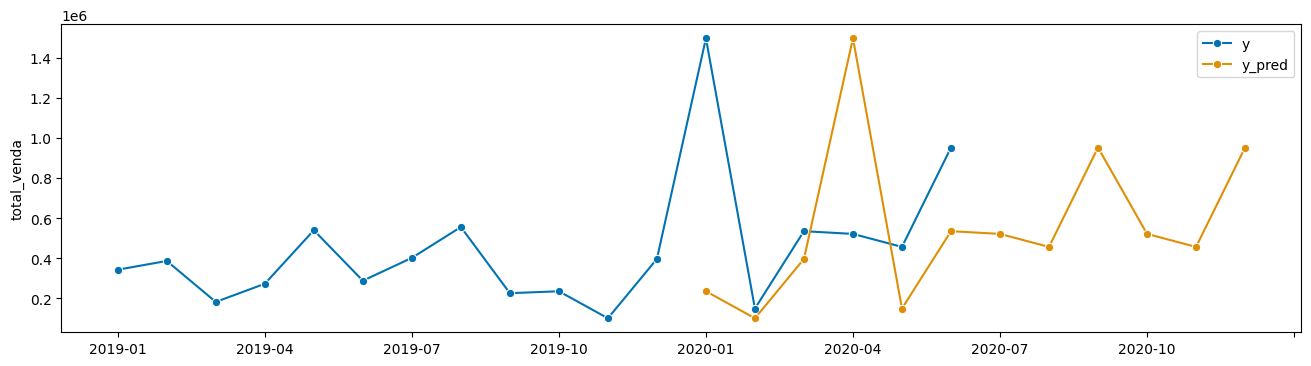

In [168]:
vendas['periodo'] = vendas['date'].dt.to_period('M')
y = vendas.groupby('periodo').sum('total_venda')['total_venda']

# Crie o objeto forecaster
forecaster = NaiveForecaster(strategy="last", sp=3)

# Ajuste o forecaster aos dados de vendas
forecaster.fit(y)

# Faça a previsão
y_pred = forecaster.predict(fh)

# Plote as previsões e os dados passados
plot_series(y, y_pred, labels=["y", "y_pred"])


# Em comparação com o forecasting do Power BI ficou muito parecido. O desenho segue a mesma estrutura. Com valores muito parecidos. Mas voltanod 1 mês, afim de comparação, o skitime se sai melhor. Enquando a diferença do real 
# para o power BI, em Julho, deu R$5.519,75 o primeiro modelo do skitime uma diferença de R$2.480,55.

## Previsão Receitas

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='total_receita'>)

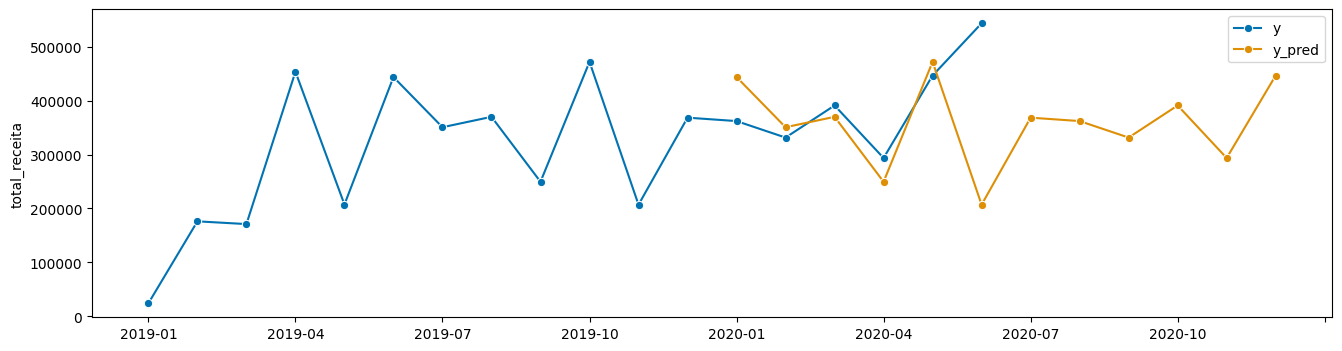

In [170]:
receitas['periodo'] = receitas['date'].dt.to_period('M')
y = receitas.groupby('periodo').sum('total_receita')['total_receita']

# Crie o objeto forecaster
forecaster = NaiveForecaster(strategy="last", sp=7)

# Ajuste o forecaster aos dados de receitas
forecaster.fit(y)

# Faça a previsão
y_pred = forecaster.predict(fh)

# Plote as previsões e os dados passados
plot_series(y, y_pred, labels=["y", "y_pred"])

## Previsão inadimplencia

In [ ]:
inadimplência_mensal['periodo'] = inadimplência_mensal['date'].dt.to_period('M')
y = inadimplência_mensal.groupby('periodo').sum('taxa_inadimplencia')['taxa_inadimplencia']

# Crie o objeto forecaster
forecaster = NaiveForecaster(strategy="last", sp=7)

# Ajuste o forecaster aos dados de receitas
forecaster.fit(y)

# Faça a previsão
y_pred = forecaster.predict(fh)

# Plote as previsões e os dados passados
plot_series(y, y_pred, labels=["y", "y_pred"])

# Exportando dados

In [55]:
vendas.to_csv(r"./data/novos_dados/df_venda.csv", sep=';', decimal=',')
receitas.to_csv(r"./data/novos_dados/df_receita.csv", sep=';', decimal=',')

In [54]:
inadimplência_mensal.to_csv(r"./data/novos_dados/df_inadimplencia.csv", sep=';', decimal=',')

date
2019-01-01    3.429070e+05
2019-02-01    3.864485e+05
2019-03-01    1.821828e+05
2019-04-01    2.727428e+05
2019-05-01    5.396077e+05
2019-06-01    2.879812e+05
2019-07-01    4.018100e+05
2019-08-01    5.554970e+05
2019-09-01    2.257888e+05
2019-10-01    2.353725e+05
2019-11-01    1.006634e+05
2019-12-01    3.965532e+05
2020-01-01    1.496667e+06
2020-02-01    1.492971e+05
2020-03-01    5.349560e+05
2020-04-01    5.212653e+05
2020-05-01    4.564445e+05
2020-06-01    9.519753e+05
Name: total_venda, dtype: float64

In [180]:
vendas['seguradora'].value_counts()

seguradora
72    330
66    280
44    163
31    144
55     52
64     39
21     39
23     25
6      24
78     18
75     15
13     15
62     10
77     10
35      9
83      9
81      8
19      6
42      6
74      5
24      5
54      4
43      4
79      4
33      3
38      3
58      3
41      3
68      2
56      2
51      1
4       1
Name: count, dtype: int64

In [181]:
receitas['seguradora'].value_counts()

seguradora
72    317
66    265
44    158
31    116
64     36
55     34
21     31
23     17
6      16
83     16
13     11
43      6
19      6
81      6
77      5
42      5
74      5
79      5
54      5
41      3
35      3
75      3
62      3
58      3
56      2
24      1
38      1
4       1
Name: count, dtype: int64